# Project 3: Applying CNNs

Project based on image classification using CNNs. The model below will classify an image as containing the officially licensed Razorback or not.

In [57]:
#Cell 1 - Imports for CNN image classification

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import random
import copy
import os

Classes: ['Not_Razorback', 'Razorbacks']
Total images: 100
Training images: 70
Testing images: 30


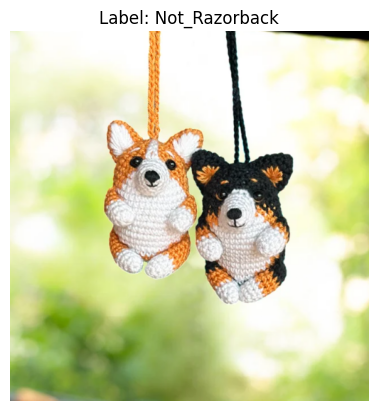

In [35]:
#Cell 2 — Initial Data loading to verify images are read correctly

#Path to images
#Heirarchy: ./Not_Razorback/*.png and ./Razorbacks/*.png
#Originally did 25 of each (50 total), but expanded to 50 of each (100 total) since I had the time
data_path = './'

#For now, only convert images to tensors. Resizing will be added later
basic_transform = transforms.ToTensor()

#Use ImageFolder since we have folder-per-class structure. Makes the classification of the images really simple
dataset = datasets.ImageFolder(root=data_path, transform=basic_transform)

# Split into train/test (70/30 split)
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

#Dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

#Information about the dataset
print("Classes:", dataset.classes)
print(f"Total images: {len(dataset)}")
print(f"Training images: {len(train_dataset)}")
print(f"Testing images: {len(test_dataset)}")

#Display a sample image to confirm reading works
sample_img, sample_label = dataset[12]
plt.imshow(np.transpose(sample_img.numpy(), (1, 2, 0)))
plt.title(f"Label: {dataset.classes[sample_label]}")
plt.axis("off")
plt.show()


In [36]:
#Cell 3 - Initialize randomness

#I liked how the CelebA notebook initialized randomness.
#I'll be mimicking that here, as well as the resizing.
#I found that just replacing the dataset with the transformed one was easiest.
#Perhaps not practical for huge datasets, but fine for this small one.

train_transform = transforms.Compose([
    transforms.Resize((500, 500)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize((500, 500)),
    transforms.ToTensor()
])

#Reload dataset with NO transforms, so transforms only apply in splits
full_dataset = datasets.ImageFolder(root='./')

#Create train/test split
train_size = int(0.7 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_subset, test_subset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

#Apply transforms to each split
train_dataset = datasets.ImageFolder(root='./', transform=train_transform)
test_dataset = datasets.ImageFolder(root='./', transform=test_transform)

#ImageFolder loads the full dataset; we need to map the subset
train_dataset.samples = [full_dataset.samples[i] for i in train_subset.indices]
test_dataset.samples = [full_dataset.samples[i] for i in test_subset.indices]

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("Augmented dataset ready.")
print("Train images:", len(train_dataset))
print("Test images:", len(test_dataset))
print("Classes:", train_dataset.classes)


Augmented dataset ready.
Train images: 70
Test images: 30
Classes: ['Not_Razorback', 'Razorbacks']


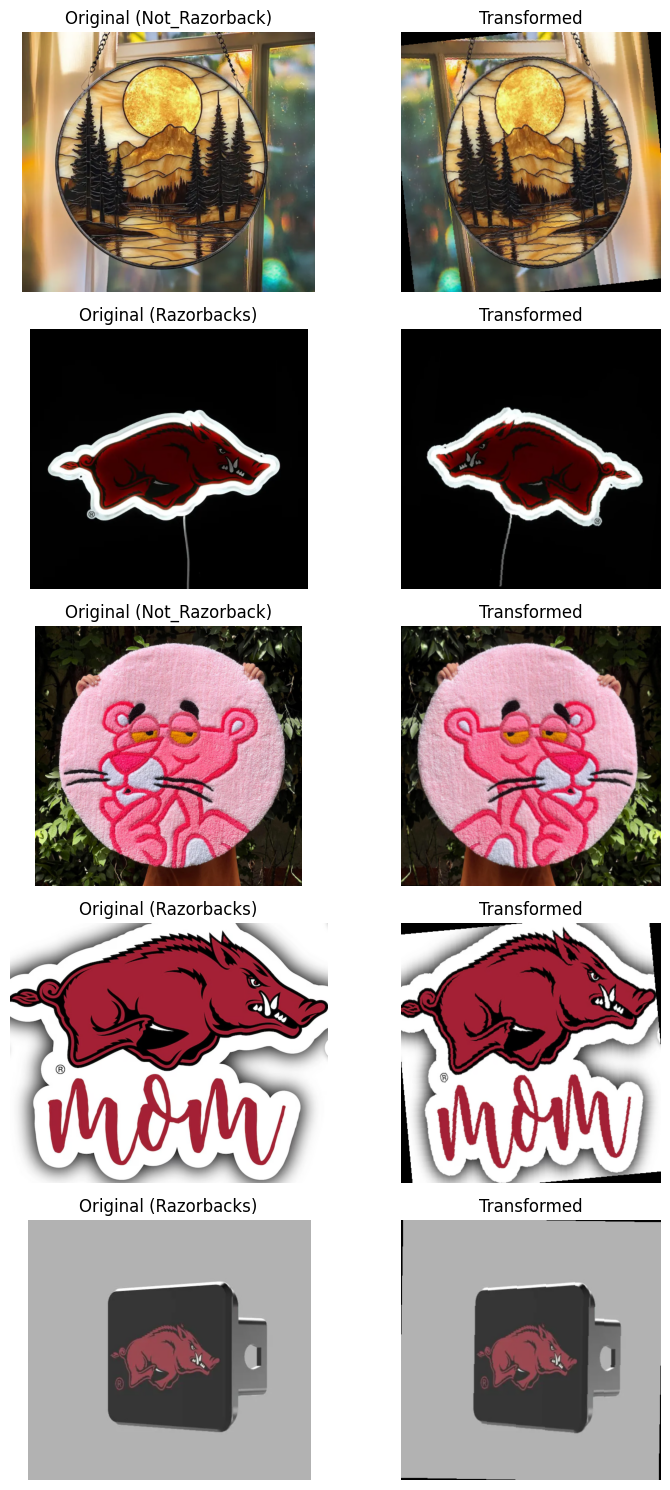

In [37]:
#Cell 4 — Visualize augmentation

#How many images to visualize
num_images = 5

#Sample indices from the full dataset
indices = random.sample(range(len(full_dataset)), num_images)

fig, axes = plt.subplots(num_images, 2, figsize=(8, num_images * 3))

for i, idx in enumerate(indices):
    #Load original image
    img_path, label = full_dataset.samples[idx]
    original = Image.open(img_path).convert("RGB")
    
    #Apply train transform (randomness)
    transformed = train_transform(original)

    #Convert transformed image back to numpy for plotting
    transformed_np = np.transpose(transformed.numpy(), (1, 2, 0))

    # --- Left column: original image ---
    axes[i, 0].imshow(original)
    axes[i, 0].set_title(f"Original ({full_dataset.classes[label]})")
    axes[i, 0].axis("off")

    # --- Right column: transformed image ---
    axes[i, 1].imshow(transformed_np)
    axes[i, 1].set_title("Transformed")
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()


In [38]:
#Cell 5 - Define CNN model

#pulled straight from CelebA example

#For the next few cells, using the same architecture first, 
#then changing if improvements are needed

# •	Use nn.Sequential() to build a stack of layers.
# •	Layer 1: Conv2d(3→32) → ReLU → MaxPool → Dropout.
# •	Layer 2: Conv2d(32→64) → ReLU → MaxPool → Dropout.
# •	Layer 3: Conv2d(64→128) → ReLU → MaxPool.
# •	Layer 4: Conv2d(128→256) → ReLU.
# •	Purpose: progressively extract hierarchical features from images.

model = nn.Sequential()

model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1))
model.add_module('relu1', nn.ReLU())
model.add_module('pool1', nn.MaxPool2d(kernel_size=2))
model.add_module('dropout1', nn.Dropout(p=0.5))

model.add_module('conv2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1))
model.add_module('relu2', nn.ReLU())
model.add_module('pool2', nn.MaxPool2d(kernel_size=2))
model.add_module('dropout2', nn.Dropout(p=0.5))

model.add_module('conv3', nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1))
model.add_module('relu3', nn.ReLU())
model.add_module('pool3', nn.MaxPool2d(kernel_size=2))

model.add_module('conv4', nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1))
model.add_module('relu4', nn.ReLU())

In [39]:
#Cell 6 - Verify model architecture with dummy data

#pulled straight from CelebA example

# •	Create a batch of 4 dummy images (64×64 RGB).
# •	Pass through model to verify output shape.
# •	Purpose: sanity check for layer compatibility.

x = torch.ones((4, 3, 64, 64))
model(x).shape

torch.Size([4, 256, 8, 8])

In [40]:
#Cell 7 - Complete model with pooling and flattening

#pulled straight from CelebA example

# •	AvgPool2d(kernel_size=8): global average pooling to summarize spatial features.
    # • This CAN be removed, although the code would need to be modified. For instance we would need to adjust the next layer to accept a larger input.
# •	Flatten(): convert 2D feature maps into 1D vector for fully connected layers.
# •	Test output shape with dummy input.

model.add_module('pool4', nn.AvgPool2d(kernel_size=8))

model.add_module('flatten', nn.Flatten())

x = torch.ones((4, 3, 64, 64))
model(x).shape

torch.Size([4, 256])

In [41]:
#Cell 8 - Finalize model with fully connected and sigmoid layers

#pulled straight from CelebA example

# •	Linear(256→1): map features to single output in the fully connected layer.
# •	Sigmoid(): convert output to probability for binary classification.

model.add_module('fc', nn.Linear(12544, 1))

model.add_module('sigmoid', nn.Sigmoid())

In [42]:
#Cell 9 - Final model verification with dummy data

#pulled straight from CelebA example

# •	Forward pass with dummy input.
# •	Ensure output shape is (batch_size, 1).
# •	Does provide expected size

x = torch.ones((4, 3, 500, 500))
model(x).shape

torch.Size([4, 1])

In [43]:
#Cell 10 - Print model architecture

#pulled straight from CelebA example

# •	Prints all layers in the model for verification.

model

Sequential(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.5, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu4): ReLU()
  (pool4): AvgPool2d(kernel_size=8, stride=8, padding=0)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=12544, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [44]:
#Cell 11 - Set device for model training

#pulled straight from CelebA example

# •	Select cuda if available, else cpu.
# •	Move model to the selected device to ensure computations occur on the same device as input.

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [45]:
#Cell 12 - Define loss function and optimizer

#pulled straight from CelebA example

# • nn.BCELoss(): binary cross-entropy for binary classification.
# •	torch.optim.Adam: optimizer with learning rate 0.001 to update parameters.
loss_fn = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [46]:
#Cell 13 - Training loop function

#pulled straight from CelebA example

# •	Function train(model, num_epochs, train_dl, valid_dl) encapsulates the training loop.
# •	Initialize history lists for loss and accuracy.
# •	Loop over epochs:
    # •	Set model to train mode.
    # •	Forward pass on training batches, compute loss, backpropagate, optimizer step, reset gradients.
    # •	Accumulate loss and accuracy.
    # •	Set model to eval mode and compute validation metrics.
    # •	Print per-epoch training and validation accuracy.
# •	Returns history lists: training/validation loss and accuracy.
# •	Disable the training-specific behaviors with model.eval()
# •	Do the evaluation without gradient computation (for efficiency)
# •	Returns the average training and validation loss per epoch, as well as the average training and validation accuracy (the proportion of correct predictions).
# •	Allows plotting, monitoring, or further analysis of training progress.
x
def train(model, num_epochs, train_dl, valid_dl):

    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs

    for epoch in range(num_epochs):

        model.train()

        for x_batch, y_batch in train_dl:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            pred = model(x_batch)[:, 0]

            loss = loss_fn(pred, y_batch.float())

            loss.backward()

            optimizer.step()

            optimizer.zero_grad()

            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            is_correct = ((pred>=0.5).float() == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum().cpu()

        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)

        model.eval()

        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                pred = model(x_batch)[:, 0]
                loss = loss_fn(pred, y_batch.float())
                loss_hist_valid[epoch] += loss.item()*y_batch.size(0)
                is_correct = ((pred>=0.5).float() == y_batch).float()
                accuracy_hist_valid[epoch] += is_correct.sum().cpu()

        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)

        print(f'Epoch {epoch+1} accuracy: {accuracy_hist_train[epoch]:.4f} val_accuracy: {accuracy_hist_valid[epoch]:.4f}')

    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid


In [48]:
#Cell 14 - Train the model

#pulled straight from CelebA example, and updated for more epochs
#since there is a significantly lower training time

# •	Set random seed.
# •	Define num_epochs = 15. I had the additional time and wanted a higher accuracy
# •	Call train() and store results in hist.

torch.manual_seed(1)

num_epochs = 50

hist = train(model, num_epochs, train_loader, test_loader)

Epoch 1 accuracy: 0.5429 val_accuracy: 0.7000
Epoch 2 accuracy: 0.5429 val_accuracy: 0.7000
Epoch 3 accuracy: 0.6571 val_accuracy: 0.6667
Epoch 4 accuracy: 0.6286 val_accuracy: 0.8000
Epoch 5 accuracy: 0.6571 val_accuracy: 0.7000
Epoch 6 accuracy: 0.6286 val_accuracy: 0.7333
Epoch 7 accuracy: 0.7143 val_accuracy: 0.8000
Epoch 8 accuracy: 0.7429 val_accuracy: 0.8000
Epoch 9 accuracy: 0.7714 val_accuracy: 0.8667
Epoch 10 accuracy: 0.7714 val_accuracy: 0.8000
Epoch 11 accuracy: 0.7714 val_accuracy: 0.7667
Epoch 12 accuracy: 0.7143 val_accuracy: 0.7333
Epoch 13 accuracy: 0.6571 val_accuracy: 0.7333
Epoch 14 accuracy: 0.7286 val_accuracy: 0.8000
Epoch 15 accuracy: 0.7714 val_accuracy: 0.8333
Epoch 16 accuracy: 0.6857 val_accuracy: 0.7667
Epoch 17 accuracy: 0.6714 val_accuracy: 0.8333
Epoch 18 accuracy: 0.7714 val_accuracy: 0.8333
Epoch 19 accuracy: 0.7857 val_accuracy: 0.8333
Epoch 20 accuracy: 0.8143 val_accuracy: 0.8333
Epoch 21 accuracy: 0.8000 val_accuracy: 0.8667
Epoch 22 accuracy: 0.8

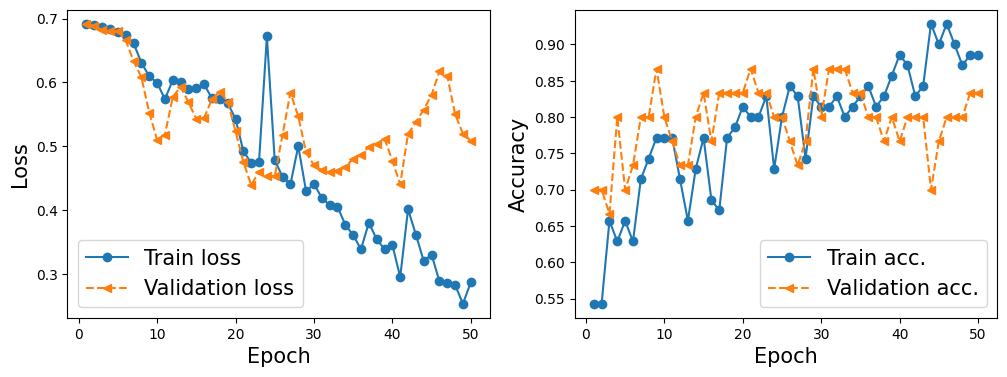

In [ ]:
#Cell 15 - Plot training history

#pulled straight from CelebA example
 
# •	Plot loss and accuracy over epochs.
# •	Left subplot: train vs validation loss.
# •	Right subplot: train vs validation accuracy.
# •	After upping the epoch count, the model produced satisfying results.

x_arr = np.arange(len(hist[0])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], '-o', label='Train acc.')
ax.plot(x_arr, hist[3], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

#plt.savefig('figures/14_17.png', dpi=300)
plt.show()

In [50]:
#Cell 16 - Evaluate on test set

#pulled straight from CelebA example

# •	Set model to eval mode.
# •	Loop over test batches without gradient computation.
# •	Compute predictions and accumulate correct counts.
# •	Divide by total number of test examples for final accuracy.
# •	Print test accuracy.

accuracy_test = 0

model.eval()

with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        pred = model(x_batch)[:, 0]
        is_correct = ((pred>=0.5).float() == y_batch).float()
        accuracy_test += is_correct.sum().cpu()

accuracy_test /= len(test_loader.dataset)

print(f'Test accuracy: {accuracy_test:.4f}')

Test accuracy: 0.8333


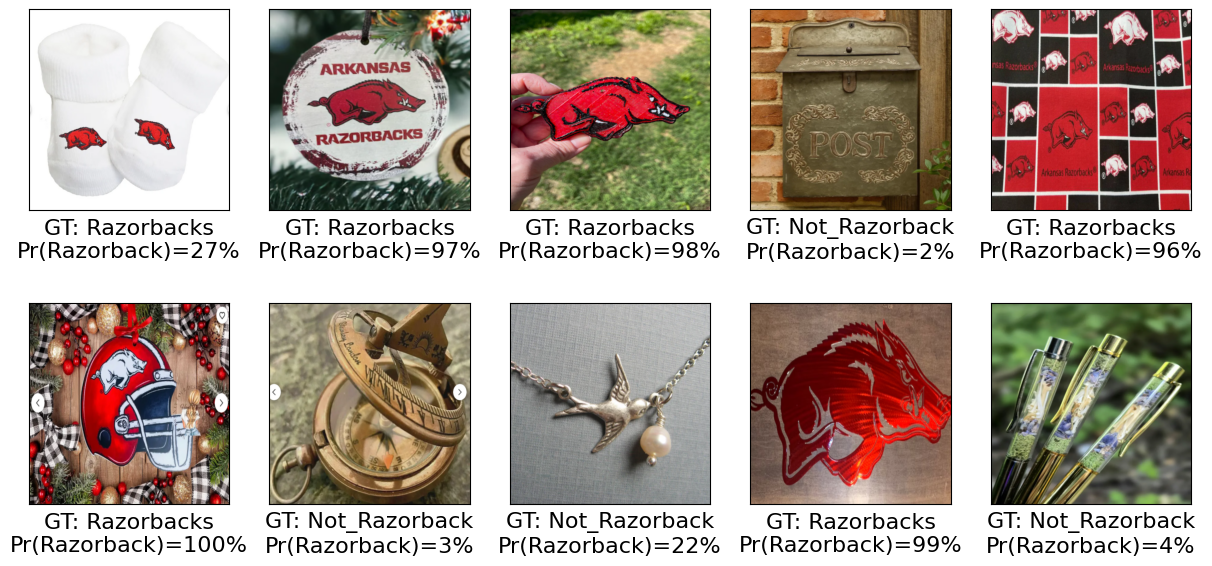

In [63]:
#Cell 17 - Visualize predictions on test images

#pulled straight from CelebA example and modified from the 'smile/not smile' syntax

# •	Compute predictions for a batch and multiply by 100 for percentage.
# •	Display subset of images in a 2×5 grid.
# •	Annotate each image with ground-truth label and predicted probability.
# •	Helps qualitatively assess model performance.
# •	If the model has a low accuracy, you might be able to tell what the problem is by looking at the results next to the pictures.

class_names = test_dataset.classes

pred = model(x_batch)[:, 0] * 100

fig = plt.figure(figsize=(15, 7))
for j in range(10, 20):
    ax = fig.add_subplot(2, 5, j-10+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(x_batch[j].cpu().permute(1, 2, 0))


    label = class_names[int(y_batch[j].item())]

    ax.text(
        0.5, -0.15,
        f'GT: {label:s}\nPr(Razorback)={pred[j]:.0f}%',
        size=16,
        horizontalalignment='center',
        verticalalignment='center',
        transform=ax.transAxes)

#plt.savefig('figures/figures-14_18.png', dpi=300)
plt.show()

In [62]:
#Cell 18 - Save the trained model

# •	Import os for file system operations.
# •	Create models directory if it doesn’t exist.
# •	Save full model using torch.save() for future reuse.


if not os.path.exists('models'):
    os.mkdir('models')

path = 'models/Group_15_CNN_FullModel.ph'

torch.save(model, path)

I've trained the first model on the same parameters that appeared in the CelebA model. Below are some hyperparameter tuning versions of the model. I will run 10 epochs of random hyperparameters. If none of the models do better than in the first 10 epochs than the original model did in 10 epochs, then I will keep the model I've already done. If it does better, I'll re-train on the new model's parameters.

In [ ]:
#Cell 19 - Hyperparameter tuning with random search

# --- Hyperparameter options ---
learning_rates = [1e-3, 5e-4, 1e-4]
dropouts = [0.3, 0.5]
batch_sizes = [16, 32]
num_trials = 3
num_epochs_trial = 10  # train each trial up to 10 epochs for comparison
baseline_epoch = 10

# --- Use your existing train/test subsets ---
train_indices = train_subset.indices
test_indices = test_subset.indices

# --- Baseline accuracy at epoch 10 ---
baseline_val_acc = hist[3][baseline_epoch-1]  # validation accuracy from your existing trained model

best_val_acc = baseline_val_acc
best_model_state = None
best_hyperparams = {'lr': None, 'dropout': None, 'batch_size': None}  # baseline

print(f"Baseline validation accuracy at epoch {baseline_epoch}: {baseline_val_acc:.4f}")

# --- Random search trials ---
for trial in range(num_trials):
    # Randomly select hyperparameters
    lr = random.choice(learning_rates)
    dropout = random.choice(dropouts)
    batch_size = random.choice(batch_sizes)
    
    print(f"\nTrial {trial+1}: lr={lr}, dropout={dropout}, batch_size={batch_size}")
    
    # --- Build trial model ---
    model_trial = nn.Sequential()
    model_trial.add_module('conv1', nn.Conv2d(3, 32, 3, padding=1))
    model_trial.add_module('relu1', nn.ReLU())
    model_trial.add_module('pool1', nn.MaxPool2d(2))
    model_trial.add_module('dropout1', nn.Dropout(p=dropout))
    
    model_trial.add_module('conv2', nn.Conv2d(32, 64, 3, padding=1))
    model_trial.add_module('relu2', nn.ReLU())
    model_trial.add_module('pool2', nn.MaxPool2d(2))
    model_trial.add_module('dropout2', nn.Dropout(p=dropout))
    
    model_trial.add_module('conv3', nn.Conv2d(64, 128, 3, padding=1))
    model_trial.add_module('relu3', nn.ReLU())
    model_trial.add_module('pool3', nn.MaxPool2d(2))
    
    model_trial.add_module('conv4', nn.Conv2d(128, 256, 3, padding=1))
    model_trial.add_module('relu4', nn.ReLU())
    
    # Adaptive pooling ensures fc input is always 256
    model_trial.add_module('pool4', nn.AdaptiveAvgPool2d((1,1)))
    model_trial.add_module('flatten', nn.Flatten())
    model_trial.add_module('fc', nn.Linear(256, 1))
    model_trial.add_module('sigmoid', nn.Sigmoid())
    
    model_trial = model_trial.to(device)
    
    # --- Loss and optimizer ---
    loss_fn = nn.BCELoss()
    optimizer = torch.optim.Adam(model_trial.parameters(), lr=lr)
    
    # --- DataLoaders ---
    train_loader_trial = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader_trial = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # --- Train trial model ---
    print("Training trial model...")
    _, _, _, val_acc = train(model_trial, num_epochs_trial, train_loader_trial, test_loader_trial)
    
    # Safely compare at epoch 10 or last epoch
    epoch_to_compare = min(baseline_epoch, len(val_acc))
    trial_val_acc = val_acc[epoch_to_compare-1]
    
    print(f"Trial {trial+1} validation accuracy at epoch {epoch_to_compare}: {trial_val_acc:.4f}")
    
    if trial_val_acc > best_val_acc:
        print("This trial beats the baseline! Updating best model.")
        best_val_acc = trial_val_acc
        best_model_state = copy.deepcopy(model_trial.state_dict())
        best_hyperparams = {'lr': lr, 'dropout': dropout, 'batch_size': batch_size}

# --- Rebuild best model for full training/evaluation ---
model_best = nn.Sequential()
model_best.add_module('conv1', nn.Conv2d(3, 32, 3, padding=1))
model_best.add_module('relu1', nn.ReLU())
model_best.add_module('pool1', nn.MaxPool2d(2))
model_best.add_module('dropout1', nn.Dropout(p=best_hyperparams['dropout'] if best_hyperparams['dropout'] else 0.5))

model_best.add_module('conv2', nn.Conv2d(32, 64, 3, padding=1))
model_best.add_module('relu2', nn.ReLU())
model_best.add_module('pool2', nn.MaxPool2d(2))
model_best.add_module('dropout2', nn.Dropout(p=best_hyperparams['dropout'] if best_hyperparams['dropout'] else 0.5))

model_best.add_module('conv3', nn.Conv2d(64, 128, 3, padding=1))
model_best.add_module('relu3', nn.ReLU())
model_best.add_module('pool3', nn.MaxPool2d(2))

model_best.add_module('conv4', nn.Conv2d(128, 256, 3, padding=1))
model_best.add_module('relu4', nn.ReLU())

model_best.add_module('pool4', nn.AdaptiveAvgPool2d((1,1)))
model_best.add_module('flatten', nn.Flatten())
model_best.add_module('fc', nn.Linear(256, 1))
model_best.add_module('sigmoid', nn.Sigmoid())

model_best = model_best.to(device)

if best_model_state is not None:
    model_best.load_state_dict(best_model_state)
    print("\nBest trial model loaded.")
else:
    print("\nNo trial beat the baseline. Baseline model remains the best choice.")

print("Best validation accuracy at epoch 10:", best_val_acc)
print("Best hyperparameters:", best_hyperparams)


Baseline validation accuracy at epoch 10: 0.8000

Trial 1: lr=0.0005, dropout=0.5, batch_size=32
Training trial model...
Epoch 1 accuracy: 0.5286 val_accuracy: 0.4333
Epoch 2 accuracy: 0.5143 val_accuracy: 0.5667
Epoch 3 accuracy: 0.4714 val_accuracy: 0.5667
Epoch 4 accuracy: 0.4714 val_accuracy: 0.4333
Epoch 5 accuracy: 0.5000 val_accuracy: 0.4333
Epoch 6 accuracy: 0.5571 val_accuracy: 0.4333
Epoch 7 accuracy: 0.5571 val_accuracy: 0.6000
Epoch 8 accuracy: 0.5714 val_accuracy: 0.6333
Epoch 9 accuracy: 0.6000 val_accuracy: 0.5667
Epoch 10 accuracy: 0.7286 val_accuracy: 0.5667
Trial 1 validation accuracy at epoch 10: 0.5667

Trial 2: lr=0.001, dropout=0.5, batch_size=16
Training trial model...
Epoch 1 accuracy: 0.4286 val_accuracy: 0.4333
Epoch 2 accuracy: 0.5286 val_accuracy: 0.4333
Epoch 3 accuracy: 0.5286 val_accuracy: 0.4333
Epoch 4 accuracy: 0.5286 val_accuracy: 0.4333
Epoch 5 accuracy: 0.5286 val_accuracy: 0.4333
Epoch 6 accuracy: 0.5286 val_accuracy: 0.4333
Epoch 7 accuracy: 0.528

With the above outputs, we can see that the 3 random search iterations could not beat the 10th epoch of the original model within their own 10 epochs. Below are some code blocks for training and saving the best model if it were to be better. These code blocks SHOULD be run if the trial beat the baseline.

In [ ]:
# #Cell 20 - Full training with best hyperparameters

# #Full training settings
# num_epochs_full = 15
# save_path = './models/Group_15_CNN_FullModel.ph'

# #Best hyperparameters from the trial that beat baseline
# best_dropout = best_hyperparams['dropout']
# best_batch_size = best_hyperparams['batch_size']
# best_lr = best_hyperparams['lr']
# best_model_state = best_model_state

# #Rebuild model with best hyperparameters
# #Two separate models to avoid confusion
# model_final = nn.Sequential()
# model_final.add_module('conv1', nn.Conv2d(3, 32, 3, padding=1))
# model_final.add_module('relu1', nn.ReLU())
# model_final.add_module('pool1', nn.MaxPool2d(2))
# model_final.add_module('dropout1', nn.Dropout(p=best_dropout))

# model_final.add_module('conv2', nn.Conv2d(32, 64, 3, padding=1))
# model_final.add_module('relu2', nn.ReLU())
# model_final.add_module('pool2', nn.MaxPool2d(2))
# model_final.add_module('dropout2', nn.Dropout(p=best_dropout))

# model_final.add_module('conv3', nn.Conv2d(64, 128, 3, padding=1))
# model_final.add_module('relu3', nn.ReLU())
# model_final.add_module('pool3', nn.MaxPool2d(2))

# model_final.add_module('conv4', nn.Conv2d(128, 256, 3, padding=1))
# model_final.add_module('relu4', nn.ReLU())

# model_final.add_module('pool4', nn.AdaptiveAvgPool2d((1,1)))
# model_final.add_module('flatten', nn.Flatten())
# model_final.add_module('fc', nn.Linear(256, 1))
# model_final.add_module('sigmoid', nn.Sigmoid())

# model_final = model_final.to(device)

# #Load weights from winning trial
# model_final.load_state_dict(best_model_state)
# print("Loaded best trial weights into full model.")

# #Optimizer and loss
# loss_fn = nn.BCELoss()
# optimizer = optim.Adam(model_final.parameters(), lr=best_lr)

# #DataLoaders
# train_loader_full = DataLoader(train_dataset, batch_size=best_batch_size, shuffle=True)
# test_loader_full = DataLoader(test_dataset, batch_size=best_batch_size, shuffle=False)

# #Train full model
# print(f"Starting full training for {num_epochs_full} epochs...")
# hist_full = train(model_final, num_epochs_full, train_loader_full, test_loader_full)

# # Save the trained model
# torch.save(model_final.state_dict(), save_path)
# print(f"Full-trained model saved to {save_path}")
